# Inpainting with Diffusion

Image inpainting is the task of reconstructing missing parts of an image with the help of context provided by the remaining parts of the image, and a prompt. In the real world, inpainting is commonly used in features like object removal and noise/damage removal.

Inpainting is the foundational tool used in creating the "infinite zoom" animation.

In this implementation, we make use of RunwayML's model for stable diffusion inpainting.

Installing the stablefused library via PIP.

In [1]:
!pip install stablefused ipython

Importing required libraries.

In [2]:
import numpy as np
import torch
import math
from IPython.display import Video, display
from PIL import Image
from stablefused import InpaintDiffusion
from stablefused.utils import image_grid, pil_to_video

Initialising the model.

In [3]:
model_id = "runwayml/stable-diffusion-inpainting"
model = InpaintDiffusion(model_id=model_id, torch_dtype=torch.float16)
model.enable_attention_slicing()
model.enable_slicing()
model.enable_tiling()

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Defining our prompt(s), negative prompt(s), number of output images and seed.

The prompt tells the model what to replace the missing portions of the image with, and the negative prompt tells the model what _not_ to replace the missing portions with.

While the same seed is used, a constant combination of prompt, negative prompt, image and mask will result in the same output every time.

In [11]:
prompt = [
    "Digital illustration of a mythical creature, high quality, realistic, 8k",
    "Digital illustration of mythical creatures, high quality, realistic, 8k",
    "Digital illustration of a dragon, high quality, realistic, 8k",
    "Digital illustration of a ferocious lion, high quality, realistic, 8k",
]
negative_prompt = "cartoon, unrealistic, blur, boring background, deformed, disfigured, low resolution, unattractive"
num_images = len(prompt)
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)

Loading the original image and the mask into the notebook. Where the mask is black, information in the image is retained, but where the mask is white, diffusion is used to inpaint the image.

Original and mask image:


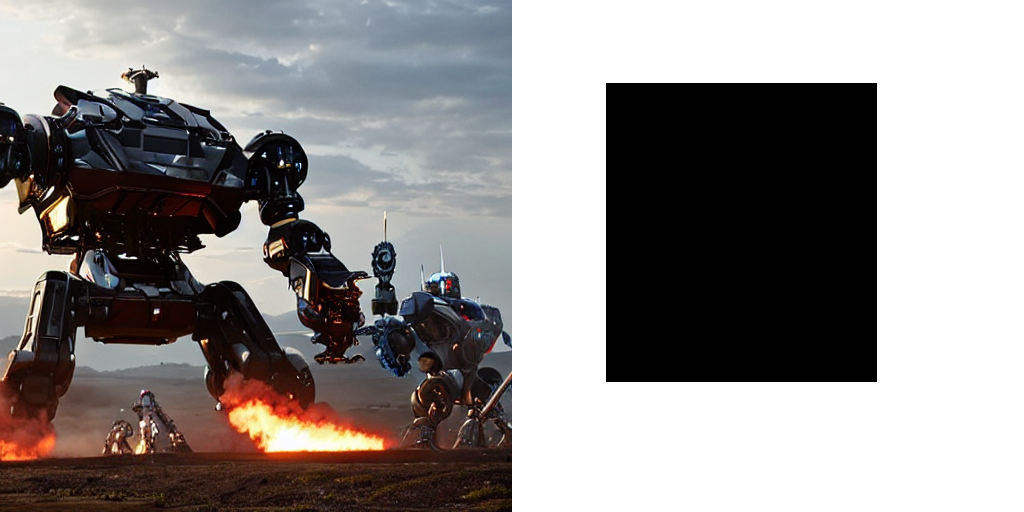

In [12]:
image_filename = "mechanical-robot-base-image.png"
mask_filename = "mask.png"

original_image = Image.open(image_filename)
mask = Image.open(mask_filename)

start_image = np.array(original_image.convert("RGB"))
mask_image = np.array(mask.convert("L"))

start_image = np.expand_dims(start_image, axis=0).repeat(num_images, axis=0)
mask_image = np.expand_dims(mask_image, axis=0).repeat(num_images, axis=0)
mask_image = mask_image.reshape(*mask_image.shape, 1)

print("Original and mask image:")
image_grid([original_image, mask], rows=1, cols=2)

Running the model on the given image, mask and prompts, and saving the resulting image(s) into `images`.

In [13]:
images = model(
    prompt=prompt,
    negative_prompt=[negative_prompt] * num_images,
    image=start_image,
    mask=mask_image,
    num_inference_steps=20,
    start_step=5,
    image_height=512,
    image_width=512,
    guidance_scale=10.0,
)

  0%|          | 0/15 [00:00<?, ?it/s]

Displaying the images in a grid:

1.	Digital illustration of a mythical creature, high quality, realistic, 8k
2.	Digital illustration of mythical creatures, high quality, realistic, 8k
3.	Digital illustration of a dragon, high quality, realistic, 8k
4.	Digital illustration of a ferocious lion, high quality, realistic, 8k


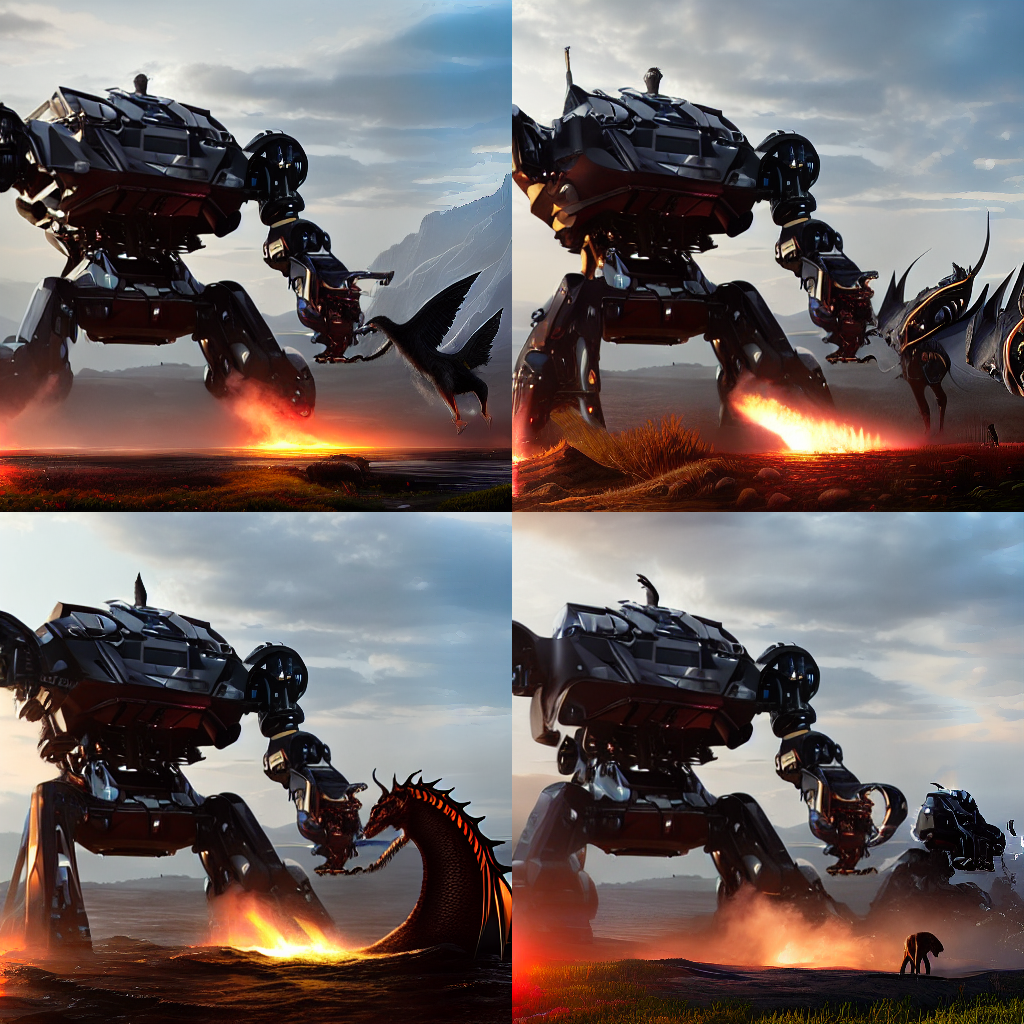

In [14]:
for i, p in enumerate(prompt):
    print(f"{i+1}.\t{p}")

image_grid(images, rows=2, cols=math.ceil(num_images / 2))